## Extract relevant articles based on conditions

In [1]:
from tqdm import tqdm
import pandas as pd
import time
import os

# get extras (headers and mdfc)
os.chdir("/home/insert_user/GDELT_GKG/extras/")
from extras_csv_headers import gkg_header, relevant_gkg_header
# bool for whether or not to work with GDELT's "enhanced" themes - for now we don't due to their pesky format
include_enhanced_themes = False

# get automatically selected themes
theme_subset = pd.read_csv("auto-theme-subset",header=0,
                           names=["theme","count"])["theme"].to_list()

# get MBFC data
df_mbfc = pd.read_csv("MBFC_features.csv",usecols=["URL","Bias Rating"])
df_mbfc = df_mbfc.rename(columns={"Bias Rating":"lean","URL":"outlet"})

In [2]:
# show some example themes
theme_subset[:10]

['EPU_POLICY_INTEREST_RATES',
 'CYBER_ATTACK',
 'UNEMPLOYMENT',
 'SURVEILLANCE',
 'UNGP_AFFORDABLE_NUTRITIOUS_FOOD',
 'STRIKE',
 'EPU_POLICY_REGULATION',
 'EPU_POLICY_CENTRAL_BANK',
 'ENV_NATURALGAS',
 'KIDNAP']

In [6]:
#------------------------------------------------------------------------------
# FUNCTIONS & SETUP
#------------------------------------------------------------------------------

def split_on_semicol(s):
    """
    Function that splits string(or nans) into list.
    """
    if isinstance(s,float) or str(s) == "nan" or not s:
        return []
    # make cell into array and remove empty items resulting from split
    return [item for item in s.split(";") if item != '']

def simplify_theme(element_set):
    """
    If using known set of themes that contain near synonyms, this
    can be used to combine theme names (dict of names to combine is
    the "theme groups" variable). 
    
    Returns set of inputted list elements.
    """
    common_elements_set = set({theme_groups[el] 
                               if el in theme_groups.keys() 
                               else el for el in element_set})
    return common_elements_set

def check_if_theme_present(list1,list2, num_overlap=1):
    """
    Function returns common elements in two lists. Can specify amount of overlap 
    required by the two lists (can for example specify that we'd like there to be
    at least 5 overlapping elements, but default is one).
    """
    if str(list1) != "nan":
        common_elements = set(list1).intersection(list2)
        if len(common_elements) >= num_overlap:
            return common_elements
    return None

def check_if_enhancedtheme_present(enh_theme,list2, num_overlap=1):
    # OBS! DOES NOT WORK WITH SCRIPT 04 - DEFUNCT
    if str(enh_theme) != "nan" and enh_theme:
        enh_theme = pd.Series(enh_theme).str.split(',',expand=True)
        enh_theme.columns = ["theme","charoff"]
        enh_theme["charoff"] = pd.to_numeric(enh_theme["charoff"])
        #enh_theme["theme_simpl"] = [theme_groups[el] 
        #                           if el in theme_groups.keys() 
        #                           else el for el in enh_theme["theme"]]
        # note that we want tht themes in original, not simplified format
        themes = enh_theme["theme"].to_list()
    
        common_elements = set(themes).intersection(list2)
        if len(common_elements) >= num_overlap:
            #common_elements = simplify_theme(common_elements)
            enh_theme.drop("theme", axis=1, inplace=True)
            charoffs = enh_theme[enh_theme["theme"].isin(common_elements)]
            return charoffs.groupby(by=["theme"]).min().to_dict()["charoff"]
    return None

def make_binary_on_nan(series_col):
    """
    Function to make non-na values integers.
    """
    return series_col.notna().astype(int)

def GCAM_to_dict(str_val):
    """
    Function for splitting the GCAM metrics and extracting 
    the important ones from eMFD sentiment measures.
    """
    kv_pairs = str_val.split(",")
    new_dict = {}
    for pair in kv_pairs:
        key, value = pair.split(":")
        new_dict[key] = value
    # get eMFD values from GCAM
    relevant_keys = ["v42.7","v42.8","v42.9","v42.10","v42.11"]
    gcam_dict = {k: v for k, v in new_dict.items() if k in relevant_keys}
    for key in relevant_keys:
        if key not in gcam_dict:
            gcam_dict[key] = 0
    return gcam_dict

In [7]:
csv_folder = "/home/insert_user/GDELT_GKG/gkg_csvs/"
os.chdir(csv_folder)
os.remove("one_year_outlets_eMFD.csv")

Suppress all the warnings because we're lazy and will fix this some other time, or never.

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

In [42]:
#------------------------------------------------------------------------------
# MAIN
#------------------------------------------------------------------------------

# set working directory
csv_folder = "/home/insert_user/GDELT_GKG/gkg_csvs/"
os.chdir(csv_folder)

# check if we're running second batch of 6months
is_second_batch_of_csvs = True
if not is_second_batch_of_csvs:
    processed_dates = []

# collect list of error files and outlets present in GDELT
error_files = []
#outlets = []
for item in tqdm(os.listdir(csv_folder)):
    if not item.endswith(".gkg.csv"): # exclude all files that are not csvs
        continue
    
    # if it's part of the dates we already processed, skip
    if is_second_batch_of_csvs and (int(item[:-8]) in processed_dates): #20220701000000: # this ic cutoff date
        continue

    # GET DATAFRAMES GKG - seems to have multiple encodings, wtf
    try:
        gkg = pd.read_csv(item, sep='\t', names=gkg_header, header=0, 
                          encoding='unicode_escape', engine='python',
                          on_bad_lines = 'skip')
    except:
        try: 
            #print("Trying utf8")
            gkg = pd.read_csv(item, sep='\t', names=gkg_header, header=0, 
                              encoding='utf-8', engine='python',
                              on_bad_lines = 'skip')
        except:
            # there's a problem with some gkg files...
            error_files.append(item)
            continue
    
    #--------------------------------------------------------------------------
    # THEMES COLUMN CLEANING
    #--------------------------------------------------------------------------
    
    # subselect columns
    gkg_lite = pd.DataFrame(gkg,columns=relevant_gkg_header)
    # fix THEMES formatting from string to list
    gkg_lite["THEMES"] = gkg_lite["THEMES"].apply(split_on_semicol)
    # get THEMES column where only relevant themes are shown
    gkg_lite["THEMES_SUBSET"] = gkg_lite["THEMES"].apply(
                                    check_if_theme_present,args=[theme_subset])

    # if enhanced themes are to be included...
    if include_enhanced_themes:
        gkg_lite["V2ENHANCEDTHEMES"] = gkg_lite["V2ENHANCEDTHEMES"].apply(split_on_semicol)
        gkg_lite["V2ENHANCEDTHEMES_SUBSET"] = gkg_lite["V2ENHANCEDTHEMES"].apply(check_if_enhancedtheme_present, args=[theme_subset] )
    
    # remove old columns
    gkg_lite.drop('THEMES', axis=1, inplace=True)
    gkg_lite.drop('V2ENHANCEDTHEMES', axis=1, inplace=True)
    
    # make sure this column is numeric
    gkg_lite["V2SOURCECOLLECTIONIDENTIFIER"] = pd.to_numeric(
        gkg_lite["V2SOURCECOLLECTIONIDENTIFIER"],
        errors="coerce", downcast="integer")
    
    # add unique outlets to list
    #outlets.extend(gkg_lite["V2SOURCECOMMONNAME"].unique())
    
    #------------------------------------------------------------------------------
    # SPEED TEST PANDAS
    #------------------------------------------------------------------------------

    # this ensures that only english (non-translated) articles are included
    pandas_gkg = gkg_lite[ (gkg_lite["V21TRANSLATIONINFO"].isna())
                             # ensures only webpages are used
                             & (gkg_lite["V2SOURCECOLLECTIONIDENTIFIER"] == 1)
                             # limits to relevant outlets with a human rating
                             #& (gkg_lite["V2SOURCECOMMONNAME"].isin(
                             #                                df_mbfc.outlet))
                             # select only articles that contain subset theme
                             & (~gkg_lite['THEMES_SUBSET'].isnull())
                             ]
    # skip rest if DF is empty
    if pandas_gkg.shape[0] == 0:
        continue
    
    # split tone
    tone_cols = ["AvgTone","PosScore","NegScore","Polarity","ActRefDens",
                 "SelfRefDens","WordCount"]
    pandas_gkg[tone_cols] = pandas_gkg.loc[:,'TONE'].str.split(',', expand=True)
    pandas_gkg[tone_cols] = pandas_gkg.loc[:,tone_cols].apply(pd.to_numeric,
                                                        errors='coerce')
    # remove unnecessary column
    pandas_gkg.drop(['V2SOURCECOLLECTIONIDENTIFIER',"V21TRANSLATIONINFO","TONE"], axis=1, inplace=True)
    # clean make binary columns on images, social media, videos
    pandas_gkg['V21RELATEDIMAGES'] = pandas_gkg.loc[:,'V21RELATEDIMAGES'].notna().astype(int)
    pandas_gkg['V21SOCIALIMAGEEMBEDS'] = pandas_gkg.loc[:,'V21SOCIALIMAGEEMBEDS'].notna().astype(int)
    pandas_gkg['V21SOCIALVIDEOEMBEDS'] = pandas_gkg.loc[:,'V21SOCIALVIDEOEMBEDS'].notna().astype(int)
    # aggregate to single col
    pandas_gkg["IMGorEMBED"] = pandas_gkg.loc[:,['V21RELATEDIMAGES',
                                                'V21SOCIALIMAGEEMBEDS',
                                                'V21SOCIALVIDEOEMBEDS']].sum(1)
    
    # clean GCAM column, turn it into dicts
    pandas_gkg["V2GCAM"] = pandas_gkg["V2GCAM"].apply(GCAM_to_dict)
    # extract values from dict into their own columns
    eMFD_cols = ['care-harm', 'fairness-cheating', 'loyalty-betrayal', 
                 'authority-subversion', 'sanctity-degradation']
    pandas_gkg[eMFD_cols] = pandas_gkg['V2GCAM'].apply(
        lambda x: pd.Series([x['v42.7'], x['v42.8'], x['v42.9'], x['v42.10'], x['v42.11']]))
    
    pandas_gkg.drop('V2GCAM', axis=1, inplace=True)
    
    # if file does not exist write header 
    if not os.path.isfile("one_year_outlets_eMFD.csv"):
        pandas_gkg.to_csv("one_year_outlets_eMFD.csv", header=pandas_gkg.columns,
                         index=False)
    else: # else it exists so append without writing the header
        pandas_gkg.to_csv("one_year_outlets_eMFD.csv", mode='a', header=False,
                         index=False)

100%|████████████████████████████████████| 33141/33141 [03:04<00:00, 179.85it/s]


## Validate the Data Extraction

Sometimes some files aren't processed, or the notebook interrupts. Let's check how much of the data we managed to get before any of that happened.

In [54]:
output = pd.read_csv("one_year_outlets_eMFD.csv")

(array([185787., 201498., 239307., 227197., 202900., 220277.,  43389.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0., 157977.,
        193364., 200758., 244029., 193758., 189818.,  34821.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,  52239., 217126.,
        263759., 181188., 197291., 258431., 208013.,  56273.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0., 119436., 246595.,
        210706., 179695., 241138., 242279.,  82348.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,  26791., 253618., 211570.,
        209963., 236715., 229607., 173094.,  12757.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

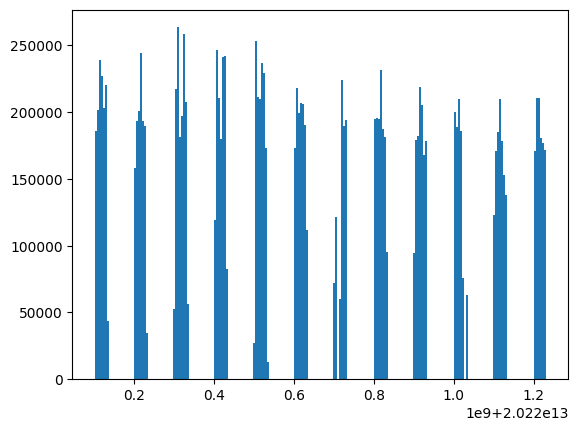

In [55]:
import matplotlib.pyplot as plt

plt.hist(output["DATE"].values,bins="auto",rwidth=None,histtype="barstacked")

Some dates are clearly missing, let's get a list of those we did process so we can rerun the code without these. Then we can rerun the code above while setting "is_second_batch" to True.

In [56]:
# get a list of daates that were processed so we can rerun the code and check if something was skipped
processed_dates = pd.Series([int(f) for f in output["DATE"].values])
processed_dates = processed_dates.unique()

In [57]:
len(processed_dates)
# should get around 35k, as this is approximately how many 15 minute intervals there are in a year.

32774

## Output Error Files and Outlet names

In [58]:
error_files = list(set(error_files))

In [59]:
print("Something went wrong with this many files: {}".format(len(error_files)))

Something went wrong with this many files: 361


In [60]:
# export files that could not be processed
pd.Series(error_files).to_csv("/home/insert_user/GDELT_GKG/extras/error_files_no_articles_could_be_extracted.csv")

In [ ]:
# export names of all outlets in GDELT
pd.Series(outlets).to_csv("/home/insert_user/GDELT_GKG/extras/all_GDELT_outlet_names.csv")